# Composition maps

In this notebook, we study the behavior of composition maps (Koopman operators) for simple dynamical systems. 

In [27]:
%load_ext nb_mypy
%nb_mypy On
    
%matplotlib ipympl

The nb_mypy extension is already loaded. To reload it, use:
  %reload_ext nb_mypy


In [28]:
from fractions import Fraction
from functools import partial
from ipywidgets import widgets, interact, IntSlider
from more_itertools import take
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from multiprocess import Pool
from nlsa.abstract_algebra import compose_by
from nlsa.dynamics import flow, flows, orbit
from nptyping import NDArray, Shape, Double
from scipy.stats import vonmises
from types import ModuleType
from typing import Callable, Generator, Tuple, TypeVar
import matplotlib as mpl
import matplotlib.pyplot as plt
import nlsa.function_algebra
import numpy as np

In [29]:
X = TypeVar('X')

def orbit(x0: X, f: Callable[[X], X]) -> Generator[X, None, None]:
    """Orbit of a point under iterated application of a map."""
    x = x0
    while True:
        yield x
        x = f(x)


<cell>3: error: Name "orbit" already defined (possibly by an import)  [no-redef]


## Working with type hints

We will annotate our code with [type hints](https://peps.python.org/pep-0484/) representing state spaces of dynamical systems and spaces of observables. Including type hints does not affect the runtime behavior of the program, but makes the code be "closer to the math", improving readability and reducing the chance of making logical errors. In addition, type-annotated programs can be checked for correctness by static type checkers such as `mypy` used in this notebook. Below, `R`, `S1`, and `F` are types representing the set of real numbers $\mathbb R$, the circle, and the space of functions $\mathcal F = \{f: X \to \mathbb R\}$, respectively. 

For our purposes, it will be sufficient to set `R` to either a `float` (64-bit floating point number), or an `NDArray` of floats whose last dimension has length 1. Moreover, we set `X` to the same type as `X`. In Python, the type for functions is `Callable`. 

In [3]:
R = float | NDArray[Shape['*, 1'], Double]
S1 = float | NDArray[Shape['*, 1'], Double]
F = Callable[[S1], R]

Finally, we will need a module `function_algebra` from the NLSA package that implements various operations on function such as composition. We will declare this module as a variable `fun` of type `ModuleType`.

In [4]:
fun: ModuleType = nlsa.function_algebra

## Circle rotation

As our first example, we consider a discrete-time rotation generated by the map $\Phi: X \to X$ such that $\Phi(x) = a + x \mod 1$, where $a$ is a real number. The following function `circle_rot` takes in a real input parameter `a` and returns a function `phi` that implements the rotation map by `a`.

As a representative observable $f \in \mathcal F$, we consider the [von Mises probability density function](https://en.wikipedia.org/wiki/Von_Mises_distribution) which is the analog of a Gaussian probability density on a periodic domain. Specifically, we have $f(x) = e^{\kappa\cos(2\pi x)}/(2\pi I_0(\kappa))$, where $\kappa$ is a positive concentration parameter (analogous to the inverse variance of a Gaussian), and $I_0$ is the modified Bessel function of the second kind of order 0. We use the implementation of the von Mises distribution provided by the SciPy library.

In [5]:
def circle_rot(a: R) -> Callable[[S1], S1]:
    """Circle rotation"""
    def phi(x: S1) -> S1:
        y = (x + a) % 1.0 
        return y
    return phi


def f_vm(kappa: R) -> Callable[[S1], R]:
    """Von Mises probability density centered at pi"""
    def f(x: S1) -> R:
        y = vonmises.pdf(2 * np.pi * x, kappa, loc=np.pi)
        return y
    return f

Recall the definition of the Koopman operator as the map $U : \mathcal F \to \mathcal F$ that composes by $\Phi$, i.e., $U f = f \circ \Phi$. Here, we implement $U$ for the circle rotation as a function `u: F -> F` that takes as input a function `f` and returns a function given by the composition of $f$ with the circle rotation map obtained by `phi_rot`. For that purpose we use the `compose_by` function from the `nlsa.abstract_algebra` module.

In [6]:
a = np.sqrt(2) / 10 
u = compose_by(fun, circle_rot(a))

To visualize the action of the Koopman operator, we apply it iteratively to the von Mises function. We use the `orbit` function from the `nlsa.dynamics` module to build a Python [generator](https://wiki.python.org/moin/Generators) that implements iterative application of the Koopman operator `u` on this observable. In this case, Koopman operator simply translates $f$ by $-a$ without changing its shape. 

interactive(children=(IntSlider(value=0, continuous_update=False, description='n', max=19), Output()), _dom_cl…

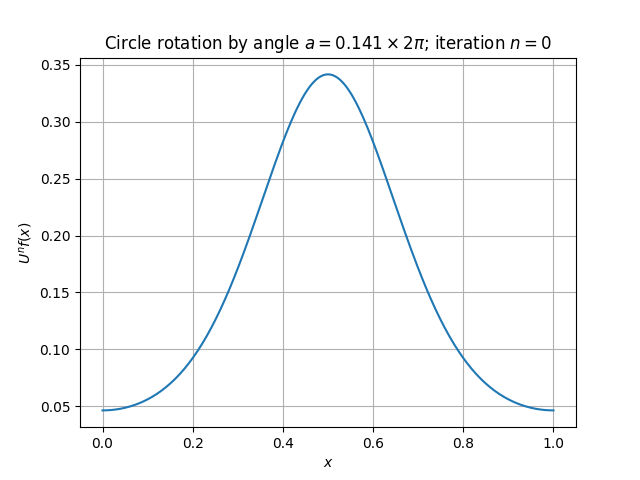

In [7]:
kappa = 1
n_iter = 20

fs = take(n_iter, orbit(f_vm(kappa), u))
xs = np.linspace(0, 1, 200)

i_fig = 1
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)
slider = IntSlider(value=0, min=0, max=n_iter - 1, continuous_update=False)


@interact(n=slider)
def plotfunc(n: int):
    f = fs[n]
    ax.cla()
    ax.plot(xs, f(xs))
    ax.grid(True)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$U^n f(x)$')
    ax.set_title(f'Circle rotation by angle $a={a:.3f}\\times 2\pi$; ' 
                 f'iteration $n= {n}$')

## Doubling map

As our next example, we consider the doubling map $\Phi: X \to X$ given by $\Phi(x) = 2 x\mod 1$.

In [8]:
def doubling_map(x: S1) -> S1:
    """Doubling map on the circle"""
    y = 2 * x % 1 
    return y

We follow a similar approach as in the rotation example to implement the action of the Koopman operator on the von Mises density. Notice that application of the Koopman operator results in a "duplication" of the function from the previous iteration. Thus, unlike the rotation map, as $n$ increases $U^n f$ becomes an increasingly oscillatory function. This indicates that $U^n f$ becomes increasingly difficult to approximate ("predict") as time increases.    

interactive(children=(IntSlider(value=0, continuous_update=False, description='n', max=9), Output()), _dom_cla…

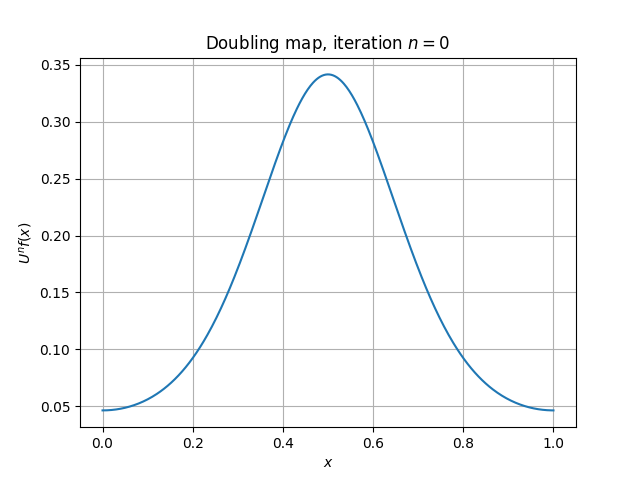

In [9]:
kappa = 1
n_iter = 10

u = compose_by(fun, doubling_map) 
fs = take(n_iter, orbit(f_vm(kappa), u))
xs = np.linspace(0, 1, 500)

i_fig = 2
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)
slider = IntSlider(value=0, min=0, max=n_iter - 1, continuous_update=False)


@interact(n=slider)
def plotfunc(n: int):
    f = fs[n]
    ax.cla()
    ax.plot(xs, f(xs))
    ax.grid(True)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$U^n f(x)$')
    ax.set_title(f'Doubling map, iteration $n= {n}$')

## Torus rotation

We now consider discrete-time dynamics on the 2-torus $\mathbb T^2$ (i.e., a periodic square). As in our one-dimensional examples we use types to represent spaces of states and observables. In what follows, we will use the type `R2` and `T2` to represent Euclidean space $\mathbb R^2$ and the 2-torus, respectively. We will set these types to `NDArray`s of floats whose last dimension has length 2. Moreover, we will use the type `F2` to represent the space of observables $\mathcal F_2 = \{f: \mathbb T^2 \to \mathbb R\}$; we set `F2` to a `Callable` mapping `X2` to `R`.  


In [10]:
R2 = NDArray[Shape['2'], Double] | NDArray[Shape['*, 2'], Double]
T2 = NDArray[Shape['2'], Double] | NDArray[Shape['*, 2'], Double]
F2 = Callable[[T2], R]

As our first example we study the torus rotation $\Phi: \mathbb T^2 \to \mathbb T^2$ given by $\Phi(x) = x + a \mod 1$ with $a = (a_1, a_2) \in \mathbb R^2$ and $x=(x_1,x_2)$. We visualize the action of the corresponding Koopman operator on a two-dimensional von Mises distribution $f$. 

In [11]:
def torus_rot(a: R2) -> Callable[[T2], T2]:
    """Torus rotation"""
    def phi(x: T2) -> T2:
        y = (x + a) % 1.0  
        return y
    return phi


def f_vm2(kappa: R2) -> Callable[[T2], R]:
    """Von Mises probability density on torus centered at (pi, pi)"""
    def f(x: T2) -> R:
        y = vonmises.pdf(2 * np.pi * x[..., 0], kappa[0], loc=np.pi) \
            * vonmises.pdf(2 * np.pi * x[..., 1], kappa[1], loc=np.pi)
        return y
    return f

If $a_1$ and $a_2$ are rationally independent, the system is measure-preserving and ergodic with respect to Lebesgue measure. This means that if we fix a number $c$ strictly smaller than the maximum value of $f$ and track the "blobs" $S_n = \{ x \in X^2 : U^n f(x) \geq c \}$ as $n$ increases, the sets $S_n$ will well-sample in the invariant measure, in the sense that for any reference set $R \subset X^2$ of positive Lebesgue measure, $S_n$ will intersect $R$ on a set of positive measure for some $n$.

interactive(children=(IntSlider(value=0, description='n', max=10), Output()), _dom_classes=('widget-interact',…

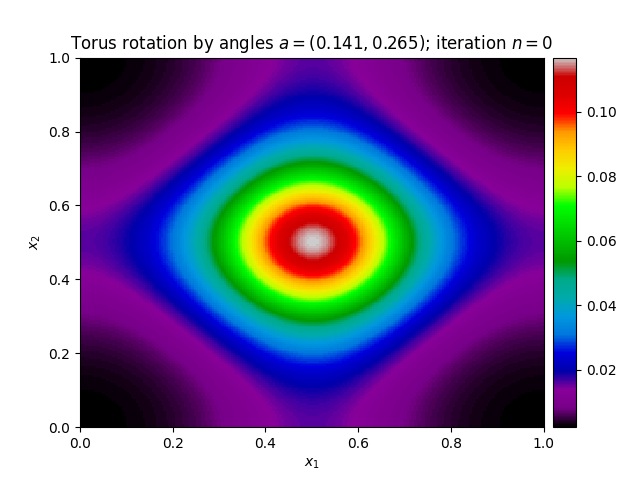

In [19]:
a = np.array([np.sqrt(2) / 10, np.sqrt(7) / 10]) 
kappa = np.array([1, 1]) 
n_iter = 11
n_plt = 201

u = compose_by(fun, torus_rot(a)) 
fs = take(n_iter, orbit(f_vm2(kappa), u))
xs, ys = np.meshgrid(np.linspace(0, 1, n_plt), np.linspace(0, 1, n_plt))
xys = np.concatenate((xs[:-1,:-1, np.newaxis],
                      ys[:-1,:-1, np.newaxis]), axis=2)

i_fig = 3
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
slider = IntSlider(value=0, min=0, max=n_iter - 1, continuous_update=True)


@interact(n=slider)
def plotfunc(n: int):
    f = fs[n]
    ax.cla()
    im = ax.pcolormesh(xs, ys, f(xys), cmap=mpl.cm.nipy_spectral)
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(f'Torus rotation by angles $a=({a[0]:.3f}, {a[1]:.3f})$; '
                 f'iteration $n= {n}$')

## Arnold's cat map

The ["cat map"](https://en.wikipedia.org/wiki/Arnold%27s_cat_map) is a classical example of a chaotic map on the 2-torus, introduced in the 1960s by the mathematician [Vladiminr Arnold](https://en.wikipedia.org/wiki/Vladimir_Arnold). The cat map $f : X^2 \to X^2$ is defined as
$$
    f(x) = A x \mod 1, \quad A = 
    \begin{pmatrix}
        2 & 1 \\
        1 & 1
    \end{pmatrix},
    \quad 
    x = 
    \begin{pmatrix}
        x_1 \\
        x_2
    \end{pmatrix}.
$$


In [13]:
def cat_map(x: T2) -> T2:
    """Cat map on the torus
    
    When operating on a single 2D vector, this function is equivalent to the 
    standard matrix-vector product a @ x. The einsum function broadcasts this 
    operation to multidimensional data arrays x, where the last dimension is 
    equal to 2. 
    """
    
    a = np.array([[2, 1], [1, 1]])
    y = np.einsum('ij,...j->...i', a, x) % 1 
    return y

We visualize the behavior of this map by applying its corresponding Koopman operator to the von Mises density used in the torus rotation example. Notice the stretching and twisting of the "blob" under the action of the Koopman operator.

interactive(children=(IntSlider(value=0, continuous_update=False, description='n', max=10), Output()), _dom_cl…

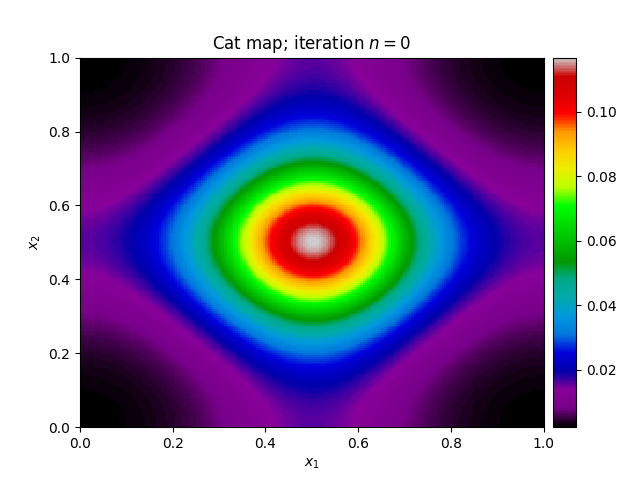

In [14]:
kappa = np.array([1, 1]) 
n_iter = 11

u = compose_by(fun, cat_map) 
fs = take(n_iter, orbit(f_vm2(kappa), u))
xs, ys = np.meshgrid(np.linspace(0, 1, n_plt), np.linspace(0, 1, n_plt))
xys = np.concatenate((xs[:-1,:-1, np.newaxis],
                      ys[:-1,:-1, np.newaxis]), axis=2)

i_fig = 4
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
slider = IntSlider(value=0, min=0, max=n_iter - 1, continuous_update=False)


@interact(n=slider)
def plotfunc(n: int):
    f = fs[n]
    ax.cla()
    im = ax.pcolormesh(xs, ys, f(xys), cmap=mpl.cm.nipy_spectral)
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(f'Cat map; iteration $n= {n}$')

## Continuous-time systems

We now consider continuous-time systems on $\mathbb T^2$ generated by *vector fields* $v: \mathbb T^2 \to \mathbb R^2$. Every such vector field $v$ has an associated initial-value problem,
$$
    \frac{dx}{dt} = v(x(t)), \quad x(0) = x, \quad x \in \mathbb T^2,
$$
where $x$ is the initial condition and $x(t)$ the solution at time $t \in \mathbb R$. Solving the initial-value problem at every $x \in \mathbb T^2$ defines a flow $\Phi^t : \mathbb T^2 \to \mathbb T^2$, $t\in \mathbb R$, such that $\Phi^t(x) = x(t)$.  

Similarly to our discrete-time examples, we represent the vector field $v$ by a Python function, here of signature `v: T2 -> R2`. We use use the function `flow` provided by the `nlsa.dynamics` module to approximate the flow $\Phi^t$. In order to speed up the evaluation of $\Phi^t$ on many initial conditions we use the `MultiProcess` module to solve the corresponding initial-value problem in parallel over initial conditions.   

In [15]:
pl = Pool(6)

## Stepanoff flow

As our first example, we consider the vector field $v(x) = (v_1(x), v_2(x))$ with components
$$
    v_1(x) = v_2(x) + (1-\alpha)(1 - \cos x_2), \quad v_2(x) = \alpha(1-\cos(x_1-x_2)), \quad x = (x_1, x_2),
$$
where $\alpha \in \mathbb R$ is a parameter and we take $x_1,x_2 \in [0, 2 \pi)$. 

In [16]:
def stepanoff_vec(alpha: float) -> Callable[[T2], R2]:
    """Vector field of the Stepanoff flow on the 2-torus"""
    def v(x: T2) -> R2:
        y = np.empty(2)
        y[1] = alpha * (1 - np.cos(x[0] - x[1]))
        y[0] = y[1] + (1 - alpha) * (1 - np.cos(x[1]))
        return y
    return v


def f_vm2pi(kappa: R2) -> Callable[[T2], R]:
    """Von Mises probability density on torus centered at (pi, pi)"""
    def f(x: T2) -> R:
        y = vonmises.pdf(x[..., 0], kappa[0], loc=np.pi) \
            * vonmises.pdf(x[..., 1], kappa[1], loc=np.pi)
        return y
    return f

We visualize the action of the Koopman operator for the Stepanoff flow by applying it to the von Mises density.

In [20]:
alpha = np.sqrt(20)
dt = 0.1
kappa = np.array([0.5,0.5])
n_plt_x = 16
#n_plt_x = 128
n_iter = 50

theta = np.linspace(0, 2 * np.pi, n_plt_x)
x1, x2 = np.meshgrid(theta, theta)
x = np.concatenate((x1[:-1, :-1, np.newaxis], x2[:-1, :-1, np.newaxis]), 
                   axis=2)
x = np.reshape(x, ((n_plt_x - 1) ** 2, 2))
x1 = x1 / np.pi
x2 = x2 / np.pi
u = compose_by(fun, flows(stepanoff_vec(alpha), dt * np.arange(n_iter)))
ft = u(f_vm2pi(kappa))
fxt = np.array(pl.map(ft, x))

interactive(children=(IntSlider(value=0, description='n', max=49), Output()), _dom_classes=('widget-interact',…

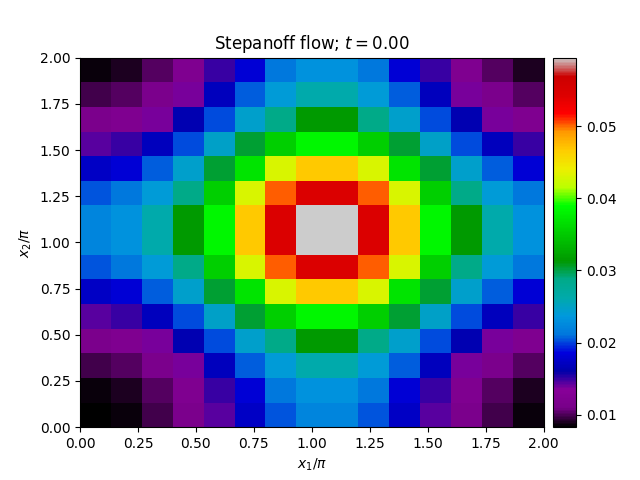

In [21]:
i_fig = 5
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
slider = IntSlider(value=0, min=0, max=n_iter -1, continuous_update=True)


@interact(n=slider) 
def plotfunc(n):
    t = n * dt
    fx = np.reshape(fxt[:, n], (n_plt_x - 1, n_plt_x - 1))
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, fx, cmap=mpl.cm.nipy_spectral)
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$x_1/\\pi$')
    ax.set_ylabel('$x_2/\\pi$')
    ax.set_title(f"Stepanoff flow; $t = {t:.2f}$")

## Lorenz 63 system

The [Lorenz 63 system](https://en.wikipedia.org/wiki/Lorenz_system) (L63) is a continuous-time dynamical system on $\mathbb R^3$ generated by the vector field $v: \mathbb R^3 \to \mathbb R^3$ with $v=(v_1,v_2,v_3)$ and
$$
    v_1(x_1,x_2,x_3) = \sigma(x_2-x_1), \quad v_2(x_1,x_2,x_3) = x_1(\rho - x_3) - x_2, \quad v_3(x_1,x_2,x_3) = x_1 x_2 - \beta x_3.
$$
In the above, $x_1, x_2, x_3$ are the coordinates of the point $x=(x_1,x_2,x_3) \in \mathbb R^3$, and $\sigma$, $\rho$, and $\beta$ are parameters. 

The L63 system was proposed in 1963 by mathematician and meteorologist [Edward Lorenz](https://en.wikipedia.org/wiki/Edward_Norton_Lorenz) as an idealized model of atmospheric convection. Lorenz derived the model by Fourier truncation of the Boussinesq equations for a fluid heated from below in a two-dimensional domain. The parameters $\sigma$, $\rho$, and $\beta$ correspond to the Prandtl number, Rayleigh number, and domain aspect ratio of the underlying Boussinesq system. Numerical solution of the L63 equation carried by Lorenz and his collaborators are recognized as the first demonstration of chaos in a deterministic system. Since its inception, the L63 system has been studied extensively from both theoretical and applied perspectives, and serves as an important test system for data-driven analysis and forecasting techniques.

In what follows we examine the behavior of the Koopman operator for the L63 system, implemented similarly to our Stepanoff flow example. We introduce types `R3` and `F3` representing points in Euclidean space $\mathbb R^3$ and observables in the space $\mathcal F_3 := \{f: \mathbb R^3 \to \mathbb R}$.

In [22]:
R3 = NDArray[Shape['3'], Double] | NDArray[Shape['*, 3'], Double]
F3 = Callable[[R3], R]

In [23]:
def l63_vec(sigma: float, rho: float, beta: float) -> Callable[[R3], R3]:
    """Vector field of the Lorenz 63 system"""
    def v(x: R3) -> R3:
        y: R3 = np.empty(3)
        y[0] = sigma * (x[1] - x[0])
        y[1] = x[0] * (rho - x[2]) - x[1]
        y[2] = x[0] * x[1] - beta * x[2]
        return y
    return v

We visualize the action of the Koopman operator on the observable that records the first coordinate of the L63 state, i.e., $f(x) = x_1$ for $x=(x_1,x_2,x_3)$. 

In [24]:
def f_x(x: R3) -> R:
    y = x[..., 0]
    return y

In [25]:
rho = 28.
sigma = 10.
beta = 8/3
dt = 0.1
n_spin = 1000
n_plt = 1000
#n_plt = 40000
n_iter = 35
i_fig = 6

v = l63_vec(sigma, rho, beta)
phi = flows(v, dt * np.arange(n_spin, n_spin + n_plt))
x = phi(np.array([1., 0., 0.]))
u = compose_by(fun, flows(v, dt * np.arange(n_iter)))
ft = u(f_x)
fxt = np.array(pl.map(ft, x))


interactive(children=(IntSlider(value=0, description='n', max=34), Output()), _dom_classes=('widget-interact',…

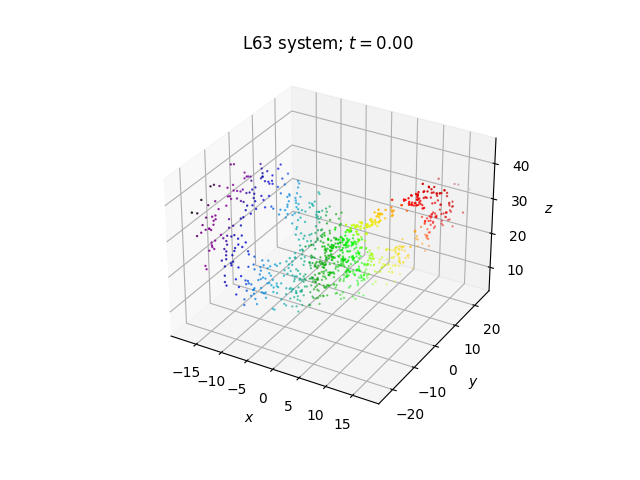

In [26]:
i_fig = 6
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig = plt.figure(num=i_fig)
ax = fig.add_subplot(projection='3d')
slider = IntSlider(value=0, min=0, max=n_iter -1, continuous_update=True)


@interact(n=slider) 
def plotfunc(n):
    t = n * dt
    ax.cla()
    im = ax.scatter(x[:,0], x[:, 1], x[:,2], c=fxt[:, n], s=0.5, cmap=mpl.cm.nipy_spectral)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.set_title(f"L63 system; $t = {t:.2f}$")